# Code

In [6]:
its_jupyter_notebook = True

In [7]:
import pandas as pd
import time
import os
import re
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from util.params_dataloader import load_windows_and_multipliers
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    RNADatasetNT500,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
    clean_nt_dataframes_before_class_input,
)
from train_binary_cl import seed_worker, obtain_train_dataset, obtain_val_dataset, obtain_val_dataset_paris, obtain_train_dataset_paris, undersample_df, obtain_policies_object, obtain_dataset_object, get_per_sample_from_proportion
from config import *

In [8]:
def print_df_len(df_len, xlim = 1_000, bins = 400):
    df_len[df_len.label == 'p'].length.hist(bins = bins)
    plt.xlim((0,xlim))
    plt.show()
    df_len[df_len.label == 'sn'].length.hist(bins = bins)
    plt.xlim((0,xlim))
    plt.show()
    df_len[df_len.label == 'enhn'].length.hist(bins = bins)
    plt.xlim((0,xlim))
    plt.show()

In [9]:
DIMENSION = 200
FINETUNING = False
TRAIN_HQ = False
SPECIE = 'all'

scaling_factor = 5
min_n_groups_train = 5
max_n_groups_train = 80
min_n_groups_val = 80
max_n_groups_val = 80


DESIRED_DIM_TEST = 500

In [10]:
per_sample_p = 0.25
proportion_sn = 0.5
proportion_hn = 0.3
proportion_en = 0.2

# Esecuzione data loader train

### Dataset

In [78]:
n_epochs = 10
sn_len_1 = []
sn_len_2 = []
enhn_len_1 = []
enhn_len_2 = []
pos_len_1 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train, policies_train = obtain_train_dataset_paris(DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))
        else:
            if sample.policy == 'smartneg':
                sn_len_1.append(box.x2-box.x1)
                sn_len_2.append(box.y2-box.y1)
            else:
                enhn_len_1.append(box.x2-box.x1)
                enhn_len_2.append(box.y2-box.y1)
            matrix_area_neg.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))

        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)

pos_len = pos_len_1+pos_len_2
label_p = ['p' for i in range(len(pos_len))]
sn_len = sn_len_1+sn_len_2
label_sn = ['sn' for i in range(len(sn_len))]
enhn_len = enhn_len_1+enhn_len_2
label_enhn = ['enhn' for i in range(len(enhn_len))]
label = label_p + label_sn + label_enhn
length = pos_len + sn_len + enhn_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/43007 [00:00<?, ?it/s]

  0%|          | 0/43116 [00:00<?, ?it/s]

  0%|          | 0/42899 [00:00<?, ?it/s]

  0%|          | 0/43219 [00:00<?, ?it/s]

  0%|          | 0/43184 [00:00<?, ?it/s]

  0%|          | 0/43427 [00:00<?, ?it/s]

  0%|          | 0/43184 [00:00<?, ?it/s]

  0%|          | 0/42839 [00:00<?, ?it/s]

  0%|          | 0/43434 [00:00<?, ?it/s]

  0%|          | 0/42732 [00:00<?, ?it/s]

(0.0, 1000.0)

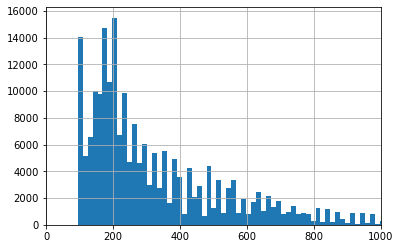

In [79]:
df_len[df_len.label == 'sn'].length.hist(bins = 400)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

(0.0, 1000.0)

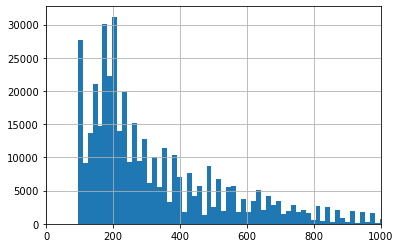

In [80]:
df_len[df_len.label == 'p'].length.hist(bins = 400)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

(0.0, 1000.0)

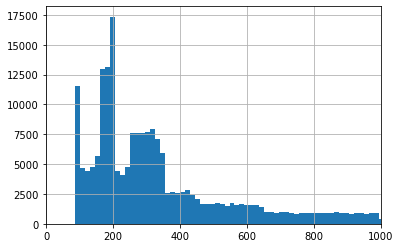

In [81]:
df_len[df_len.label == 'enhn'].length.hist(bins = 400)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

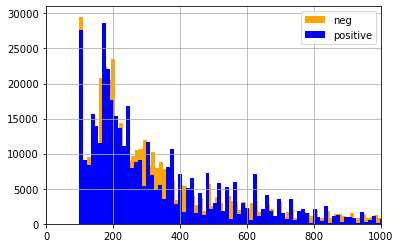

In [82]:
df_len[(df_len.label == 'sn')|(df_len.label == 'enhn')].length.hist(bins = 500, color = 'orange', label = 'neg')
df_len[df_len.label == 'p'].length.hist(bins = 500, color = 'blue', label = 'positive')
plt.legend()
plt.xlim((0,1_000))
plt.show()

In [83]:
q = 0.9
np.quantile(matrix_area_pos, q), np.quantile(matrix_area_neg, q)

(554.1953622938059, 642.6235289810046)

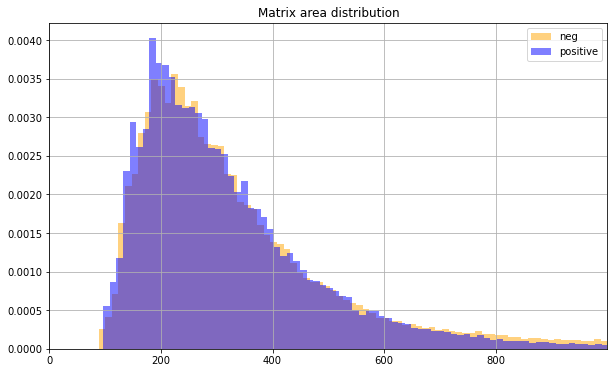

In [84]:
plt.figure(figsize = (10, 6))
pd.Series(matrix_area_neg).hist(bins=500, label='neg', color='orange', alpha=0.5, density = True)  # Set transparency for neg
pd.Series(matrix_area_pos).hist(bins=500, label='positive', color='blue', alpha=0.5, density = True)  # Set transparency for positive
plt.title(f'Matrix area distribution')
plt.legend()
plt.xlim((0, np.mean(matrix_area_pos) * 3))
plt.show()

In [11]:
# plot_sample(sample, plot_interaction_negatives=True)

In [12]:
(df_len.label == 'p').value_counts()

False    430974
True     430906
Name: label, dtype: int64

In [13]:
df_len[df_len.length == 5970].label.value_counts()

p       1455
enhn     771
sn       741
Name: label, dtype: int64

In [14]:
df_len[df_len.length == 100].label.value_counts()

p       23398
sn      11945
enhn    10801
Name: label, dtype: int64

In [15]:
df_len[df_len.length == 200].label.value_counts()

p       15276
enhn     8649
sn       7310
Name: label, dtype: int64

In [16]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

p       42665
sn      22140
enhn    19852
Name: label, dtype: int64


p       127189
enhn     67733
sn       63426
Name: label, dtype: int64


In [17]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

0.35416666666666663

In [18]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

0.5625

In [19]:
#balance set
assert abs(df_len.label.value_counts().p/df_len.shape[0] - 0.5) < 0.05

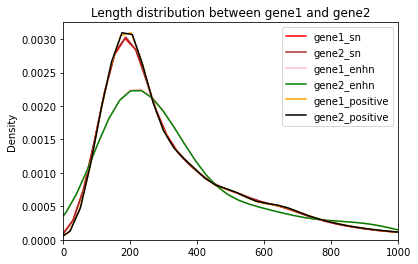

In [20]:
sns.kdeplot(sn_len_1, color = 'red', label = 'gene1_sn')
sns.kdeplot(sn_len_2, color = 'brown', label = 'gene2_sn')
sns.kdeplot(enhn_len_1, color = 'pink', label = 'gene1_enhn')
sns.kdeplot(enhn_len_2, color = 'green', label = 'gene2_enhn')
sns.kdeplot(pos_len_1, color = 'orange', label = 'gene1_positive')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.xlim((0,1_000))
plt.show()

### Dataloader 

In [21]:
dataset_train, policies_train = obtain_train_dataset_paris(DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, 32, drop_last=False)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn_nt2, num_workers=2)

In [ ]:
n_total = 40
shapes_rna1 = []
shapes_rna2 = []
for _, (samples, labels) in tqdm(enumerate(data_loader_train), total = n_total):
    rna1, rna2 = samples
    shapes_rna1.append(rna1.shape[-1])
    shapes_rna2.append(rna2.shape[-1])
    if _ == n_total:
        break

In [23]:
np.min(shapes_rna1)

16

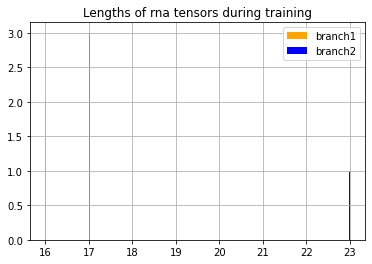

In [24]:
pd.Series(shapes_rna1).hist(bins = 300, color = 'orange', label = 'branch1')
pd.Series(shapes_rna2).hist(bins = 300, color = 'blue', label = 'branch2')
plt.legend()
#plt.xlim((0,100))
plt.title('Lengths of rna tensors during training')
plt.show()

# Validation set 

In [21]:
dataset_val, policies_val = obtain_val_dataset_paris(DIMENSION, FINETUNING, min_n_groups_val, max_n_groups_val, SPECIE, scaling_factor = 5)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17734 [00:00<?, ?it/s]

median: 200.0


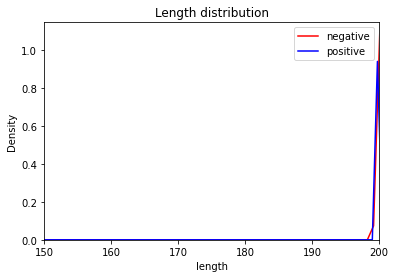

In [22]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(1)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.xlim((150, 200))
plt.legend()

# Esecuzione data loader external dataset

In [23]:
dataset_train, policies_train = obtain_train_dataset('splash', DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)

In [24]:
dataset_train

In [33]:
n_epochs = 50
sn_len_1 = []
sn_len_2 = []
enhn_len_1 = []
enhn_len_2 = []
pos_len_1 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train, policies_train = obtain_train_dataset('splash', DIMENSION, np.nan, np.nan, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
    for sample in dataset_train:
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))
        else:
            if sample.policy == 'smartneg':
                sn_len_1.append(box.x2-box.x1)
                sn_len_2.append(box.y2-box.y1)
            else:
                enhn_len_1.append(box.x2-box.x1)
                enhn_len_2.append(box.y2-box.y1)
            matrix_area_neg.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))

        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)

pos_len = pos_len_1+pos_len_2
label_p = ['p' for i in range(len(pos_len))]
sn_len = sn_len_1+sn_len_2
label_sn = ['sn' for i in range(len(sn_len))]
enhn_len = enhn_len_1+enhn_len_2
label_enhn = ['enhn' for i in range(len(enhn_len))]
label = label_p + label_sn + label_enhn
length = pos_len + sn_len + enhn_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
df_len.label.value_counts()

p       26766
sn      13556
enhn    13366
Name: label, dtype: int64

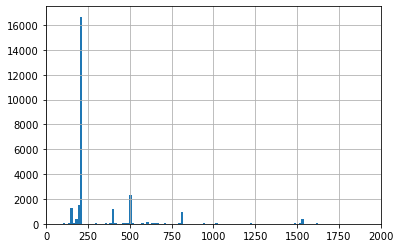

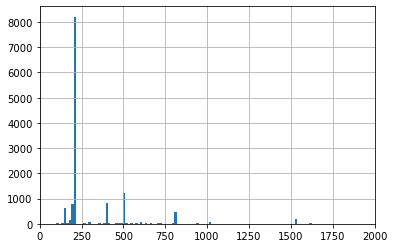

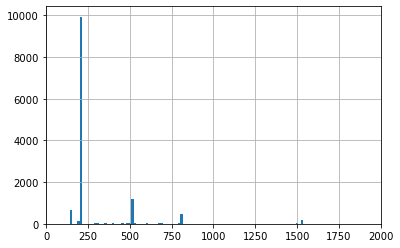

In [30]:
print_df_len(df_len, xlim = 2_000)

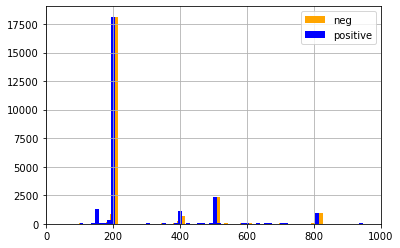

In [31]:
df_len[(df_len.label == 'sn')|(df_len.label == 'enhn')].length.hist(bins = 500, color = 'orange', label = 'neg')
df_len[df_len.label == 'p'].length.hist(bins = 500, color = 'blue', label = 'positive')
plt.legend()
plt.xlim((0,1_000))
plt.show()

# Combined dataset

In [ ]:
n_epochs = 1
batch_size = 64

for epoch in tqdm(range(n_epochs)):

    dataset_train, policies_train = obtain_train_dataset('psoralen', DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
    custom_data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn_nt3)

    neg_len_1 = []
    pos_len_1 = []
    neg_len_2 = []
    pos_len_2 = []
    matrix_area_neg = []
    matrix_area_pos = []

    for s, targets in tqdm(custom_data_loader, total = len(custom_data_loader)): #tqdm(custom_data_loader, total = len(custom_data_loader)):
        for sample in targets:
            box = sample['bbox']
            if sample['interacting']==1:
                pos_len_1.append(box.x2-box.x1)
                pos_len_2.append(box.y2-box.y1)
                matrix_area_pos.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))
            else:
                neg_len_1.append(box.x2-box.x1)
                neg_len_2.append(box.y2-box.y1)
                matrix_area_neg.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))

In [35]:
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [36]:
len(neg_len)/2

1416.0

In [37]:
len(pos_len)/2

1528.0

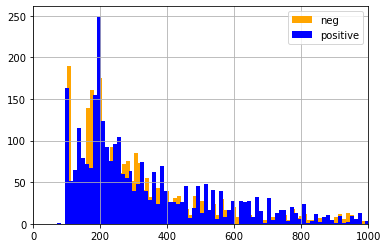

In [38]:
df_len[(df_len.label == 'sn')|(df_len.label == 'n')].length.hist(bins = 500, color = 'orange', label = 'neg')
df_len[df_len.label == 'p'].length.hist(bins = 500, color = 'blue', label = 'positive')
plt.legend()
plt.xlim((0,1_000))
plt.show()

In [39]:
q = 0.9
np.quantile(matrix_area_pos, q), np.quantile(matrix_area_neg, q)

(565.1052664183272, 661.2600368651467)

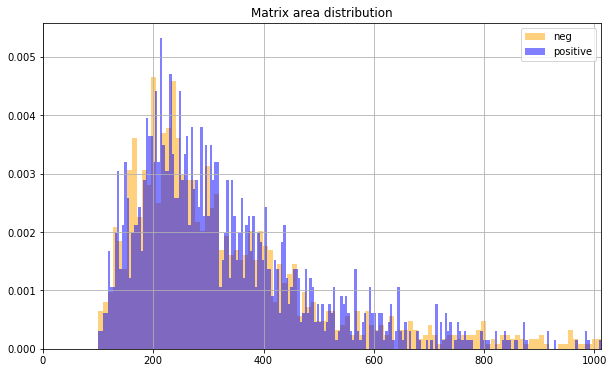

In [40]:
plt.figure(figsize = (10, 6))
pd.Series(matrix_area_neg).hist(bins=500, label='neg', color='orange', alpha=0.5, density = True)  # Set transparency for neg
pd.Series(matrix_area_pos).hist(bins=500, label='positive', color='blue', alpha=0.5, density = True)  # Set transparency for positive
plt.title(f'Matrix area distribution')
plt.legend()
plt.xlim((0, np.mean(matrix_area_pos) * 3))
plt.show()